# Problem definition

Apply regression models to predict Airbnb prices

I have commented out some codes below, but left the markdown and the codes --->because I had tried those things, but they gave me worse results...but wanted to express and share some of my thought processes and Trials. What went into these results are all the codes that are not commented out.  

In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split

# sklearn :: models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# sklearn :: evaluation metrics
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')

# Load the data

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print(df_train.shape, df_test.shape)

(51000, 29) (23111, 28)


# Feature Engineering 

In [3]:
print(df_train.columns)
df_train.head()

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,13662370,3.806662,House,Private room,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.5,Real Bed,strict,True,...,41.849684,-87.676270,Pilsen Arts Community Custom Home,Pilsen,17,97.0,https://a0.muscache.com/im/pictures/81318153/a...,60608,1.0,1.0
1,4765892,4.941642,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,2.0,Real Bed,strict,True,...,34.068613,-118.246455,Apartment 5 minutes from DTLA & Dodger Stadium,Echo Park,2,100.0,https://a0.muscache.com/im/pictures/aa00250e-0...,90012,1.0,1.0
2,21169968,4.941642,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.701958,-73.917352,"Brand New Huge 2bdr apartment(L,M train 2 min)",Bushwick,25,88.0,https://a0.muscache.com/im/pictures/d9220535-c...,11237,2.0,3.0
3,7939196,4.867534,Apartment,Entire home/apt,"{""Cable TV"",Internet,""Wireless Internet"",""Air ...",6,1.0,Real Bed,strict,True,...,40.742959,-73.990820,Grande Super Large APT !!!,Flatiron District,12,82.0,NaN,10010,1.0,3.0
4,18161036,3.663562,House,Private room,"{Internet,""Wireless Internet"",""Air conditionin...",2,1.0,Real Bed,flexible,True,...,34.046473,-117.734095,Private Cozy and Clean Rooms in Pomona,NaN,2,100.0,https://a0.muscache.com/im/pictures/e0c9b2f9-a...,91766,1.0,1.0


In [4]:
df_train.dtypes

id                          int64
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate         object
host_since                 object
instant_bookable           object
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
thumbnail_url              object
zipcode                    object
bedrooms                  float64
beds                      float64
dtype: object

In [5]:
# define the number of lines for the training set
training_lines = len(df_train)

In [6]:
# create a new dataframe (df_dataset) by concatenating training and test
df_dataset = pd.concat(objs=[df_train, df_test], axis=0)

In [7]:
df_dataset.shape

(74111, 29)

In [8]:
#I want to count all null values
print(df_dataset.isnull().sum())


accommodates                  0
amenities                     0
bathrooms                   200
bed_type                      0
bedrooms                     91
beds                        131
cancellation_policy           0
city                          0
cleaning_fee                  0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
id                            0
instant_bookable              0
last_review               15827
latitude                      0
log_price                 23111
longitude                     0
name                          0
neighbourhood              6872
number_of_reviews             0
property_type                 0
review_scores_rating      16722
room_type                     0
thumbnail_url              8216
zipcode                     966
dtype: int64


In [9]:
#dealing with nulls in review scores rating. I had tried mean, but median gave me better results.
df_dataset['review_scores_rating'].fillna((df_dataset['review_scores_rating'].median()), inplace=True)

I want to drop the null values for beds, bedrooms and bathrooms. It is a very small percentage. (Less than 0.26%)

In [10]:
# df_dataset= df_dataset.dropna(subset=['beds']) 
# df_dataset= df_dataset.dropna(subset=['bathrooms'])
# df_dataset= df_dataset.dropna(subset=['bedrooms'])


I want to deal with outliers of two categories that I believe are essentials for the ML model, the bedrooms and bathrooms. I believe those places with a high number of bathrooms and bedrooms are outliers and hostel types of places and I feel it would skew the price trends with regular places with more bathrooms and places. So I can start by seeing the type of property (by count) that they list and then filter. But before looking at the property type, I will drop the outliers bathrooms and bedrooms using the 3 std from the mean rule.

In [11]:
# print(df_dataset['bedrooms'].value_counts())
# print(df_dataset['bedrooms'].value_counts())

In [12]:
# print('mean', np.mean(df_dataset['bedrooms']))
# print('std', np.std(df_dataset['bedrooms']))

In [13]:
# #Removing the Outlier listings using the number of bedrooms
# mean_bedrooms=np.mean(df_dataset['bedrooms'])
# std_bedrooms=np.std(df_dataset['bedrooms'])

# df_dataset = df_dataset[(df_dataset['bedrooms']>mean_bedrooms-3*std_bedrooms)&(df_dataset['bedrooms']<mean_bedrooms+3*std_bedrooms)]

In [14]:
# df_dataset.shape

In [15]:
# print('mean', np.mean(df_dataset['bathrooms']))
# print('std', np.std(df_dataset['bathrooms']))

In [16]:
# #Removing the Outlier listings using the number of bathrooms
# mean_bathrooms=np.mean(df_dataset['bathrooms'])
# std_bathrooms=np.std(df_dataset['bathrooms'])

# df_dataset = df_dataset[(df_dataset['bathrooms']>mean_bathrooms-3*std_bathrooms)&(df_dataset['bathrooms']<mean_bathrooms+3*std_bathrooms)]

# df_dataset.shape

In [17]:
df_dataset.property_type.value_counts()

Apartment             49003
House                 16511
Condominium            2658
Townhouse              1692
Loft                   1244
Other                   607
Guesthouse              498
Bed & Breakfast         462
Bungalow                366
Villa                   179
Dorm                    142
Guest suite             123
Camper/RV                94
Timeshare                77
Cabin                    72
In-law                   71
Hostel                   70
Boutique hotel           69
Boat                     65
Serviced apartment       21
Tent                     18
Castle                   13
Vacation home            11
Yurt                      9
Hut                       8
Treehouse                 7
Chalet                    6
Earth House               4
Tipi                      3
Cave                      2
Train                     2
Island                    1
Lighthouse                1
Casa particular           1
Parking Space             1
Name: property_type,

******When you look at the above, I wonder how it makes sense to compare prices of an island, a hut, a dorm or an Apartment. So for trial sakes, I want to try to fit a model of the top 10 types in terms of numbers....this does risk overfitting but we can see, just for analytics sakes.

In [18]:
# choice_ptype=['Apartment','House','Condominium','Townhouse','Loft','Other','Guesthouse','Bed & Breakfast','Bungalow','Villa']
# df_dataset.property_type.isin(choice_ptype)
# print(df_dataset.head())
# df_dataset.shape

Now I want to explore the amenties column. I want to seperate and get dummies for each attribute:

In [19]:
#getting rid of the Curly brackets
df_dataset["amenities"] = df_dataset["amenities"].apply(lambda x: x.strip('{}'))

df_dataset
 


,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,...,log_price,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode
0,2,"TV,Internet,""Wireless Internet"",""Air condition...",1.5,Real Bed,1.0,1.0,strict,Chicago,True,CLOSE TO EVERYTHING VIA PUBLIC Love arts & cul...,...,3.806662,-87.676270,Pilsen Arts Community Custom Home,Pilsen,17,House,97.0,Private room,https://a0.muscache.com/im/pictures/81318153/a...,60608
1,2,"TV,Internet,""Wireless Internet"",""Air condition...",2.0,Real Bed,1.0,1.0,strict,LA,True,Bright and spacious apartment located in a qui...,...,4.941642,-118.246455,Apartment 5 minutes from DTLA & Dodger Stadium,Echo Park,2,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/aa00250e-0...,90012
2,5,"TV,""Cable TV"",""Wireless Internet"",""Air conditi...",1.0,Real Bed,2.0,3.0,moderate,NYC,True,New huge 2bdr apartment. Bushwick area. 2 min ...,...,4.941642,-73.917352,"Brand New Huge 2bdr apartment(L,M train 2 min)",Bushwick,25,Apartment,88.0,Entire home/apt,https://a0.muscache.com/im/pictures/d9220535-c...,11237
3,6,"""Cable TV"",Internet,""Wireless Internet"",""Air c...",1.0,Real Bed,1.0,3.0,strict,NYC,True,Hello travelers!!! SO my apt is located in Che...,...,4.867534,-73.990820,Grande Super Large APT !!!,Flatiron District,12,Apartment,82.0,Entire home/apt,NaN,10010
4,2,"Internet,""Wireless Internet"",""Air conditioning...",1.0,Real Bed,1.0,1.0,flexible,LA,True,"Very cozy, clean, safe and quite single house ...",...,3.663562,-117.734095,Private Cozy and Clean Rooms in Pomona,NaN,2,House,100.0,Private room,https://a0.muscache.com/im/pictures/e0c9b2f9-a...,91766
5,6,"TV,Internet,""Wireless Internet"",""Air condition...",1.0,Real Bed,2.0,3.0,strict,NYC,True,Spacious & clean 2 bdrm in classic BK brownsto...,...,4.836282,-73.933665,"Cool Brooklyn, Close to Manhattan",Bedford-Stuyvesant,71,Apartment,97.0,Entire home/apt,https://a0.muscache.com/im/pictures/8ed8be1f-d...,11221
6,5,"TV,""Cable TV"",""Wireless Internet"",""Air conditi...",2.0,Real Bed,2.0,1.0,strict,Boston,True,Enjoy a beautiful contemporary residence with ...,...,5.220356,-71.111333,Plush & Modern 2-BR near Bostons famous Newbur...,Mission Hill,0,Apartment,96.0,Entire home/apt,https://a0.muscache.com/im/pictures/03a6b9ca-f...,02130
7,2,"TV,""Cable TV"",Internet,""Wireless Internet"",Kit...",1.0,Real Bed,1.0,1.0,moderate,LA,False,Enjoy an unobstructed panoramic ocean view fro...,...,5.686975,-118.417798,Fantastic Ocean View! Executive Living,Manhattan Beach,4,Apartment,95.0,Entire home/apt,https://a0.muscache.com/im/pictures/0dce5c5f-b...,90266
8,2,"""Wireless Internet"",Kitchen,""Smoke detector"",""...",1.0,Real Bed,1.0,1.0,flexible,NYC,False,Nice bedroom in two bedroom apartment. With cl...,...,3.555348,-73.968571,Nice clean and quiet bedroom in two bedroom app,Kensington,6,Apartment,83.0,Private room,https://a0.muscache.com/im/pictures/a5b0ac0a-f...,11218
9,2,"TV,""Wireless Internet"",""Air conditioning"",Kitc...",2.0,Real Bed,4.0,1.0,strict,NYC,True,This apartment is one of those rare New York C...,...,4.234107,-73.978256,Breathtaking NYC Views & Great Location,Kips Bay,7,Apartment,94.0,Private room,https://a0.muscache.com/im/pictures/fa628319-e...,10016


In [20]:
# Gettind dummies --> Now I can use it as traits in my ML model.
df_amenities=df_dataset["amenities"].str.get_dummies(sep=',')
df_amenities


,"smooth pathway to front door""","""24-hour check-in""","""Accessible-height bed""","""Accessible-height toilet""","""Air conditioning""","""Air purifier""","""BBQ grill""","""Baby bath""","""Baby monitor""","""Babysitter recommendations""",...,Other,Oven,Pool,Refrigerator,Shampoo,Smartlock,Stove,TV,Washer,Waterfront
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,1,1,1,1,0,1,1,1,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0


In order to use it as traits, I have to know what my options are:

In [21]:
pd.options.display.max_seq_items = 2000
df_amenities.columns


Index([' smooth pathway to front door"', '"24-hour check-in"',
       '"Accessible-height bed"', '"Accessible-height toilet"',
       '"Air conditioning"', '"Air purifier"', '"BBQ grill"', '"Baby bath"',
       '"Baby monitor"', '"Babysitter recommendations"', '"Bath towel"',
       '"Bathtub with shower chair"', '"Beach essentials"', '"Bed linens"',
       '"Body soap"', '"Buzzer/wireless intercom"', '"Cable TV"',
       '"Carbon monoxide detector"', '"Changing table"',
       '"Children’s books and toys"', '"Children’s dinnerware"',
       '"Cleaning before checkout"', '"Coffee maker"', '"Cooking basics"',
       '"Disabled parking spot"', '"Dishes and silverware"', '"Doorman Entry"',
       '"EV charger"', '"Elevator in building"', '"Ethernet connection"',
       '"Extra pillows and blankets"', '"Family/kid friendly"',
       '"Fire extinguisher"', '"Fireplace guards"', '"Firm matress"',
       '"Firm mattress"', '"First aid kit"',
       '"Fixed grab bars for shower & toilet"', '"F

In [22]:
# transform the zipcode to integer
df_dataset['zipcode'] = pd.to_numeric(df_dataset['zipcode'], errors='coerce', downcast='integer')

In [23]:
# get dummies for anything that I would want to use in my ML model to train.
df_zipcode = pd.get_dummies(df_dataset['zipcode'])
df_bed_type = pd.get_dummies(df_dataset['bed_type'])
df_cancellation_policy = pd.get_dummies(df_dataset['cancellation_policy'])
df_room_type = pd.get_dummies(df_dataset['room_type'])
df_property_type = pd.get_dummies(df_dataset['property_type'])
df_city = pd.get_dummies(df_dataset['city'])
df_property_type = pd.get_dummies(df_dataset['property_type'])
df_cleaning_fee = pd.get_dummies(df_dataset['cleaning_fee'])
df_neighbourhood = pd.get_dummies(df_dataset['neighbourhood'])
df_host_has_profile_pic = pd.get_dummies(df_dataset['host_has_profile_pic'])
df_instant_bookable  = pd.get_dummies(df_dataset['instant_bookable'])
df_host_response_rate = pd.get_dummies(df_dataset['host_response_rate'])


In [24]:
# concatenate my datasets
df_dataset = pd.concat([df_dataset,df_instant_bookable, df_zipcode, df_bed_type,df_cancellation_policy,df_room_type,df_property_type,df_city, df_amenities, df_neighbourhood, df_cleaning_fee,df_host_response_rate], axis=1).fillna(0.0)

In [25]:
# split the dataset into train and test again
df_train = df_dataset[:training_lines]
df_test = df_dataset[training_lines:]

In [26]:
X_columns = ['bathrooms','beds','Gym','bedrooms','latitude','longitude','review_scores_rating','"Private bathroom"','number_of_reviews']+list(df_city.columns)+list(df_room_type.columns)+list(df_cancellation_policy.columns)+list(df_instant_bookable.columns)+list(df_bed_type.columns)

y_column = ['log_price']

In [27]:
# handle missing values
df_train = df_train[X_columns + y_column]
print(df_train.shape)
df_train = df_train.fillna(0.0)
print(df_train.shape)

(51000, 31)
(51000, 31)


# Model Training

In [28]:
# split the data using sklearn

threshold = 0.8
X = df_train[X_columns]
y = df_train[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold, shuffle=True)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (40800, 30)
y_train (40800, 1)
X_test (10200, 30)
y_test (10200, 1)


In [29]:
# train a RandomForest regression
model = RandomForestRegressor(n_estimators=100, n_jobs=4)
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)

# Model Evaluation

RMSE 0.4090044


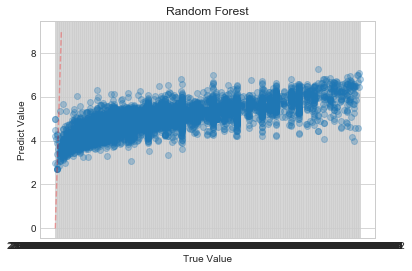

In [30]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE', round(rmse, 7))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(range(0,10), range(0,10), '--r', alpha=0.3, label='Line1')
plt.title('Random Forest')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.show()

# Prepare submission

In [31]:
df_prediction = df_test[X_columns].fillna(0.0)
df_test['log_price'] = model.predict(df_prediction)
df_test[['id', 'log_price']]

C:\Users\Alka.Patel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,log_price
0,986942,4.282827
1,16436737,4.216155
2,18209634,4.152372
3,15027024,3.838592
4,18074243,4.925254
5,8446914,5.330592
6,19362916,4.439833
7,16116059,6.130517
8,20912583,4.758796
9,13573101,4.800161


In [32]:
df_test[['id', 'log_price']].to_csv('Alka_submission_16.csv', index=False)